In [1]:
%matplotlib notebook

import sys, os
sys.path.insert(0, '../../../../vision/')
sys.path.append('../../../../../pytorch-segmentation-detection/')

# Use second GPU -- change if you want to use a first one
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

from pytorch_segmentation_detection.datasets.pascal_voc import PascalVOCSegmentation
import pytorch_segmentation_detection.models.fcn as fcns
from pytorch_segmentation_detection.transforms import (ComposeJoint,
                                                       RandomHorizontalFlipJoint,
                                                       RandomScaleJoint,
                                                       CropOrPad,
                                                       ResizeAspectRatioPreserve)

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms

from matplotlib import pyplot as plt

import numpy as np
from PIL import Image

from sklearn.metrics import confusion_matrix

# Helper functions to be able to get mask-out values out of training

def flatten_logits(logits, number_of_classes):
    """Flattens the logits batch except for the logits dimension"""
    
    logits_permuted = logits.permute(0, 2, 3, 1)
    logits_permuted_cont = logits_permuted.contiguous()
    logits_flatten = logits_permuted_cont.view(-1, number_of_classes)
    
    return logits_flatten

def flatten_annotations(annotations):
    
    return annotations.view(-1)

def get_valid_annotations_index(flatten_annotations, mask_out_value=255):
    
    return torch.squeeze( torch.nonzero((flatten_annotations != mask_out_value )), 1)

number_of_classes = 21

labels = range(number_of_classes)

train_transform = ComposeJoint(
                [
                    RandomHorizontalFlipJoint(),
                    #[ResizeAspectRatioPreserve(greater_side_size=348),
                    # ResizeAspectRatioPreserve(greater_side_size=348, interpolation=Image.NEAREST)],
                    # RandomScaleJoint(low=0.9, high=1.1),
                    # [CropOrPad(output_size=(348, 348)), CropOrPad(output_size=(348, 348), fill=255)],
                     [transforms.ToTensor(), None],
                     [transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), None],
                     [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
                ])

trainset = PascalVOCSegmentation('datasets',
                                 download=False,
                                 joint_transform=train_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)



valid_transform = ComposeJoint(
                [
                     [transforms.ToTensor(), None],
                     [transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), None],
                     [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
                ])

valset = PascalVOCSegmentation('datasets',
                               train=False,
                               download=False,
                               joint_transform=valid_transform)


valset_loader = torch.utils.data.DataLoader(valset, batch_size=1,
                                            shuffle=False, num_workers=2)

# Define the validation function to track MIoU during the training
def validate():
    
    fcn.eval()
    
    overall_confusion_matrix = None

    for image, annotation in valset_loader:

        image = Variable(image.cuda())
        logits = fcn(image)

        # First we do argmax on gpu and then transfer it to cpu
        logits = logits.data
        _, prediction = logits.max(1)
        prediction = prediction.squeeze(1)

        prediction_np = prediction.cpu().numpy().flatten()
        annotation_np = annotation.numpy().flatten()

        # Mask-out value is ignored by default in the sklearn
        # read sources to see how that was handled

        current_confusion_matrix = confusion_matrix(y_true=annotation_np,
                                                    y_pred=prediction_np,
                                                    labels=labels)

        if overall_confusion_matrix is None:


            overall_confusion_matrix = current_confusion_matrix
        else:

            overall_confusion_matrix += current_confusion_matrix
    
    
    intersection = np.diag(overall_confusion_matrix)
    ground_truth_set = overall_confusion_matrix.sum(axis=1)
    predicted_set = overall_confusion_matrix.sum(axis=0)
    union =  ground_truth_set + predicted_set - intersection

    intersection_over_union = intersection / union.astype(np.float32)
    mean_intersection_over_union = np.mean(intersection_over_union)
    
    fcn.train()

    return mean_intersection_over_union



<IPython.core.display.Javascript object>


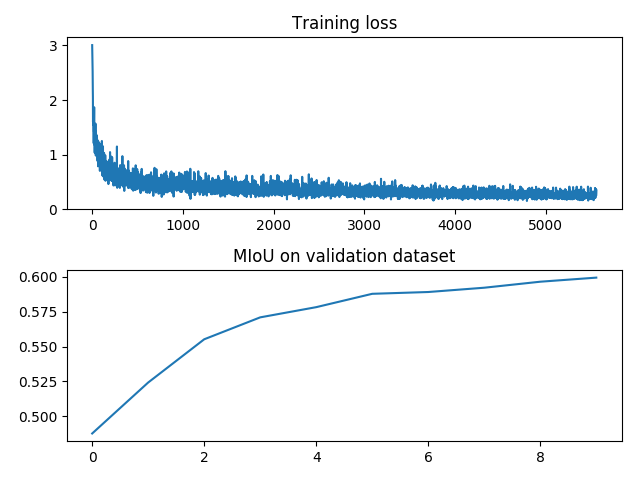

In [2]:

# Create the training plot
loss_current_iteration = 0
loss_history = []
loss_iteration_number_history = []

validation_current_iteration = 0
validation_history = []
validation_iteration_number_history = []

f, (loss_axis, validation_axis) = plt.subplots(2, 1)

loss_axis.plot(loss_iteration_number_history, loss_history)
validation_axis.plot(validation_iteration_number_history, validation_history)
loss_axis.set_title('Training loss')
validation_axis.set_title('MIoU on validation dataset')

plt.tight_layout()

In [3]:
## Define the model and load it to the gpu
fcn = fcns.FCN_32s(num_classes=21)
fcn.cuda()

## Define the loss and load it to gpu

criterion = nn.CrossEntropyLoss(size_average=False).cuda()

optimizer = optim.Adam(fcn.parameters(), lr=0.000001, weight_decay=0.0005)



In [4]:
best_validation_score = 0

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs
        img, anno = data
        
        # We need to flatten annotations and logits to apply index of valid
        # annotations. All of this is because pytorch doesn't have tf.gather_nd()
        anno_flatten = flatten_annotations(anno)
        index = get_valid_annotations_index(anno_flatten, mask_out_value=255)
        anno_flatten_valid = torch.index_select(anno_flatten, 0, index)

        # wrap them in Variable
        # the index can be acquired on the gpu
        img, anno_flatten_valid, index = Variable(img.cuda(), ), Variable(anno_flatten_valid.cuda()), Variable(index.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        logits = fcn(img)
        logits_flatten = flatten_logits(logits, number_of_classes=21)
        logits_flatten_valid = torch.index_select(logits_flatten, 0, index)
        
        loss = criterion(logits_flatten_valid, anno_flatten_valid)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.data[0] / logits_flatten_valid.size(0)) 
        if i % 20 == 19:
            
            
            loss_history.append(running_loss / 20)
            loss_iteration_number_history.append(loss_current_iteration)
            
            loss_current_iteration += 1
            
            loss_axis.lines[0].set_xdata(loss_iteration_number_history)
            loss_axis.lines[0].set_ydata(loss_history)

            loss_axis.relim()
            loss_axis.autoscale_view()
            loss_axis.figure.canvas.draw()
            
            running_loss = 0.0
        
        
            
    current_validation_score = validate()
    validation_history.append(current_validation_score)
    validation_iteration_number_history.append(validation_current_iteration)

    validation_current_iteration += 1

    validation_axis.lines[0].set_xdata(validation_iteration_number_history)
    validation_axis.lines[0].set_ydata(validation_history)

    validation_axis.relim()
    validation_axis.autoscale_view()
    validation_axis.figure.canvas.draw()

    # Save the model if it has a better MIoU score.
    if current_validation_score > best_validation_score:

        torch.save(fcn.state_dict(), 'fcn_32s_newbest.pth')
        best_validation_score = current_validation_score
            
            

print('Finished Training')

Finished Training


In [5]:
best_validation_score

0.59952867666790888